In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch
from torch import optim
import torch.nn as nn
from torchvision import datasets
import torchvision.transforms as transforms
from sklearn.metrics import confusion_matrix

<b>1. Loading the data

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [6]:
# build transform
transform = transforms.Compose([
    transforms.ToTensor(),
    ]) 

# choose the training and test datasets
datasets_path = os.getcwd()
train_data = datasets.MNIST(datasets_path, train = True,
                              download = False, transform = transform)
test_data = datasets.MNIST(datasets_path, train=False,
                             download = False, transform = transform)

train_size = len(train_data)
test_size = len(test_data)

# build the data loaders
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, shuffle = False)

# specify the image classes
classes = [f"{i}" for i in range(10)]

<b>2. The model

In [7]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()

        self.act_function = nn.ReLU()
        self.dropout = nn.Dropout(p=0.3)
        layers = [1, 6, 16, 120, 84, 10]

        self.conv1 = torch.nn.Conv2d(layers[0], layers[1], 5, padding = 2)
        self.conv2 = torch.nn.Conv2d(layers[1], layers[2], 5)
        self.fc1 = torch.nn.Linear(5 * 5 * layers[2], layers[3])
        self.fc2 = torch.nn.Linear(layers[3], layers[4])
        self.fc3 = torch.nn.Linear(layers[4], layers[5])


    def forward(self, x):
        x = self.conv1(x)
        x = self.act_function(x)
        x = torch.nn.functional.max_pool2d(x, 2)
        x = self.dropout(x)

        x = self.conv2(x)
        x = self.act_function(x)
        x = torch.nn.functional.max_pool2d(x, 2)
        x = self.dropout(x)

        x = x.view(x.size(0), -1)

        x = self.fc1(x)
        x = self.act_function(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = self.act_function(x)
        x = self.dropout(x)

        x = self.fc3(x)
        x = torch.nn.functional.log_softmax(x, dim = 1)

        return x

<b>3. Training the model

In [14]:
def train_model(model, criterion, optimizer, nepochs, scheduler=None):
    train_losses = []
    test_losses = []
    acc_eval = []

    for epoch in range(nepochs):
        train_loss = 0.
        valid_loss = 0.

        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data = data.to(device = device)
            target = target.to(device = device)

            # clear the gradients of all optimized variables
            optimizer.zero_grad()

            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)

            # calculate the batch loss
            loss = criterion(output, target)

            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()

            # perform a single optimization step (parameter update)
            optimizer.step()

            # update training loss
            train_loss += loss.item() * data.size(0)

        ######################    
        # validate the model #
        ######################
        model.eval()
        correct = 0
        for data, target in test_loader:
            with torch.no_grad():
                data = data.to(device = device)
                target = target.to(device = device)

                # forward pass: compute predicted outputs by passing inputs to the model
                output = model(data)

                # calculate the batch loss
                loss = criterion(output, target)

                # update average validation loss 
                valid_loss += loss.item()*data.size(0)
                pred = output.data.max(1, keepdim=True)[1]
                correct += pred.eq(target.data.view_as(pred)).sum().item()

        # calculate average losses
        train_loss = train_loss/len(train_loader.dataset)
        valid_loss = valid_loss/len(test_loader.dataset)
        acc_eval.append(correct/len(test_loader.dataset)*100)
        train_losses.append(train_loss)
        test_losses.append(valid_loss)
        scheduler.step(valid_loss)

        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, train_loss, valid_loss))
        
    X = range(1,nepochs+1)
    plt.plot(X, train_losses, color="red", label='Training loss')
    plt.plot(X, test_losses, color="green", label='Test loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Train and Test Losses")
    plt.legend()
    plt.show()
    plt.plot(X,acc_eval,color='blue',label='Accuracy')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy Score (%)")
    plt.title("Accuracy Score")
    plt.legend()
    plt.show()

Epoch: 0 	Training Loss: 2.101111 	Validation Loss: 0.967463
Epoch: 1 	Training Loss: 0.890466 	Validation Loss: 0.359206
Epoch: 2 	Training Loss: 0.545618 	Validation Loss: 0.232797
Epoch: 3 	Training Loss: 0.415654 	Validation Loss: 0.185711
Epoch: 4 	Training Loss: 0.342962 	Validation Loss: 0.152937


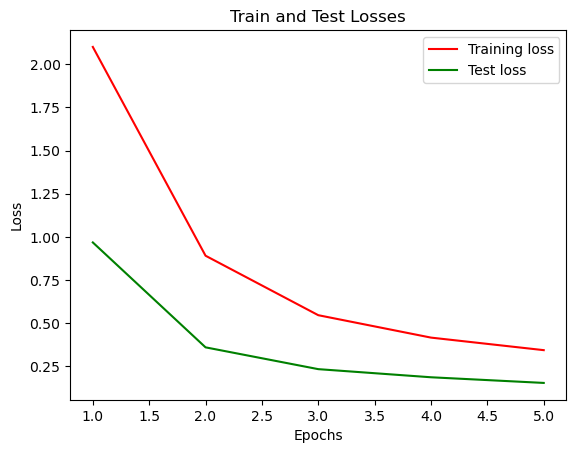

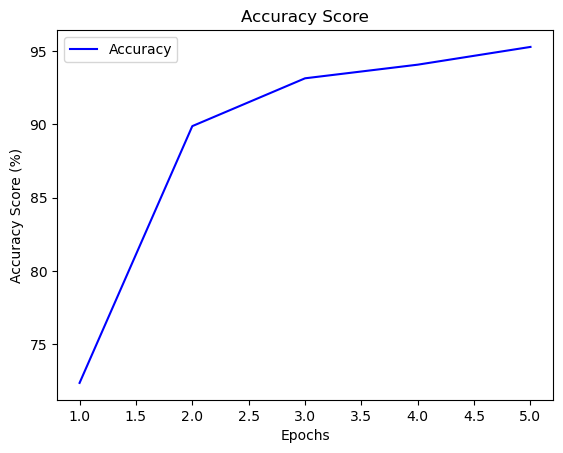

In [10]:
model = LeNet().to(device = device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = .01)
nepochs = 5
train_model(model, criterion, optimizer, nepochs)

Epoch: 0 	Training Loss: 0.487113 	Validation Loss: 0.105185
Epoch: 1 	Training Loss: 0.190673 	Validation Loss: 0.066503
Epoch: 2 	Training Loss: 0.148215 	Validation Loss: 0.051156
Epoch: 3 	Training Loss: 0.126375 	Validation Loss: 0.043162
Epoch: 4 	Training Loss: 0.113047 	Validation Loss: 0.037025


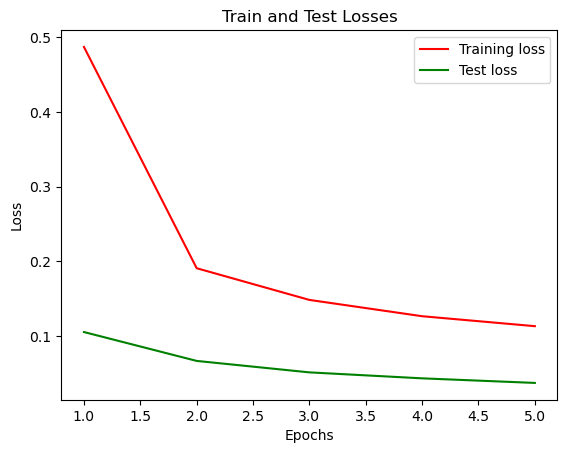

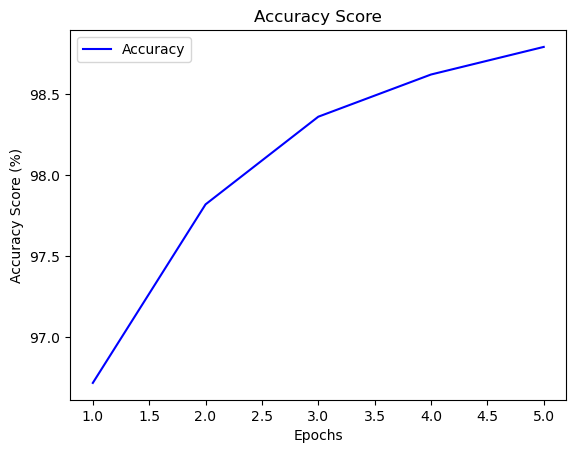

In [15]:
model = LeNet().to(device = device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
nepochs = 5
train_model(model, criterion, optimizer, nepochs, scheduler=scheduler)

<b>4. Saving the model

In [16]:
torch.save(model.state_dict(), "mnist_trained_model.pth")

<b>5. Confusion Matrix

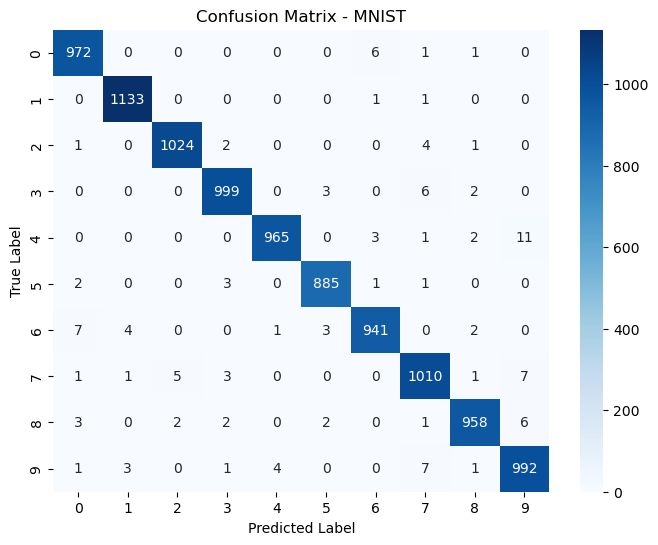

In [17]:
def evaluate_model(model, test_loader, device):
    model.load_state_dict(torch.load("mnist_trained_model.pth")) 
    model.eval()

    y_true = []
    y_pred = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.data.max(1, keepdim=True)[1]
            
            y_true.extend(target.cpu().numpy())
            y_pred.extend(pred.cpu().numpy())

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=np.arange(10), yticklabels=np.arange(10))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix - MNIST')
    plt.show()

# Call function after training
model = LeNet()
evaluate_model(model, test_loader, device)

<b>6. Predicting...

In [19]:
model = LeNet() 
model.load_state_dict(torch.load("mnist_trained_model.pth"))
model.eval()  

# Define transformation for input
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Load a sample image from MNIST dataset (or use your own image)
from PIL import Image

image_path = "MNIST"  # Replace with actual image path
image = Image.open(image_path).convert("L")  # Convert to grayscale
image = transform(image).unsqueeze(0)  # Add batch dimension

# Perform inference
with torch.no_grad():
    output = model(image)
    predicted_label = output.argmax(dim=1).item()

# Display the image and prediction
plt.imshow(image.squeeze(), cmap="gray")
plt.title(f"Predicted Label: {predicted_label}")
plt.axis("off")
plt.show()

PermissionError: [Errno 13] Permission denied: 'C:\\Users\\suvom\\OneDrive\\SUVOMITA ROY\\Internship\\Assessment5\\MNIST'